## CS 439 - Introduction to Data Science
### Spring 2019

# Lab 3: Data Cleaning and Visualization

### Due Date: Sunday February 17, 2019 by 11:59 PM ###

### Instructions
This lab is presented as a notebook. Please execute the cells that are already completed and your task is to fill in the code
between ### BEGIN SOLUTION ### and ### END SOLUTION ###. 

#### Important: Please do not add any new cells or change the order of cells. If you have questions, please contact the courseS staff.

In this lab, you will be working with a dataset from NYPD containing data on calls to the New York Police Department. Information about the datasets can be found https://opendata.cityofnewyork.us/

## Setup

Note that after activating matplotlib to display figures inline via the IPython magic `%matplotlib inline`, we configure a custom default figure size. Virtually every default aspect of matplotlib [can be customized](https://matplotlib.org/users/customizing.html).

In [4]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

# Part 1:Getting Data

We will work with the NYPD Historic complaint data set. Our first task is to estimate the size of this download by looking at the number of rows, columns and using an estimated size for a column (use a reasonable value). The site metadata is available from the page
https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i

In [223]:
### BEGIN SOLUTION
size_of_byte= 8
number_of_rows = 6040000
number_of_columns = 35
estimated_size_of_the_download= size_of_column*number_of_rows*number_of_columns
estimated_size_of_the_download
# please explain how you reached the answer
# The Dimensions for the file is 6040000x35 and there are 8 bits in a byte
### END SOLUTION

1691200000

### 1.1 Download the data
This file is large (use the estimate you did above). If it takes too long to download, you may want to interrupt and download the file using a browser and URL (https://data.cityofnewyork.us/api/views/5uac-w243/rows.csv?accessType=DOWNLOAD).

In [5]:
import utils
data_dir = 'data'
data_url = 'https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD'

file_name = 'NYPD_Complaint_Data_Historic.csv'

# To retrieve the dataset, we will use the `utils.fetch_and_cache` utility from utils library. 
dest_path = utils.fetch_and_cache(data_url=data_url, file=file_name,data_dir=data_dir)
print(f'Located at {dest_path}')

Using version already downloaded: Fri Feb 15 20:52:08 2019
MD5 hash of file: bac5b482327718d2b689d2a1bdd04dd9
Located at data\NYPD_Complaint_Data_Historic.csv


### 1.2 Inspect the size of the file
It is helpful to get an idea of the size of the file. This can be done using functions in the utils library.

In [6]:
# look at the size of the file w/o opening it using OS (https://docs.python.org/3/library/os.html). You can perform
# variety of operating system related functions from this package.
### BEGIN SOLUTION
import os 
statinfo = os.stat('C:/Users/myell/Downloads/Lab 3 - Data Cleaning and Visualization/data/NYPD_Complaint_Data_Historic.csv')
statinfo.st_size

#### END SOLUTION

1898173978

In [40]:
# Using utils library, find the number of lines in the file

### BEGIN SOLUTION
from utils import line_count
with open('C:/Users/myell/Downloads/Lab 3 - Data Cleaning and Visualization/data/NYPD_Complaint_Data_Historic.csv', 'r') as f:
    line_count = 0
    for line in f:
        line_count += 1

print(line_count)

### END SOLUTION

6036806


In [7]:
# Split the file into 10 smaller files. Estimate the number of lines in each file using the count above
# files should be created in the data folder and named NYPD_Complaint_Data_Historic_1.csv, 
# NYPD_Complaint_Data_Historic_2.csv, ... NYPD_Complaint_Data_Historic_10.csv etc
# It is possible that few lines from the original file may not be saved due to rounding errors.

### BEGIN SOLUTION
import sys
orig_file = 'C:/Users/myell/Downloads/Lab 3 - Data Cleaning and Visualization/data/NYPD_Complaint_Data_Historic.csv'

csvfile = open(orig_file, 'r').readlines()
filename = 1
for i in range(len(csvfile)):
    if i % 603880  == 0:
        open('C:/Users/myell/Downloads/Lab 3 - Data Cleaning and Visualization/data/NYPD_Complaint_Data_Historic' + str(filename) + '.csv', 'w+').writelines(csvfile[i:i+603680])
        #open(orig_file + str(filename) + '.csv').writelines(csvfile[i:i+603680])
        filename += 1



### END SOLUTION

### 1.4 Check the files in the data folder
Now, we'll use a method of the `Pathlib.Path` class called `glob` to list all files in the `data` directory. You will find useful information in pathlib [docs](https://docs.python.org/3/library/pathlib.html).

Below, we use pathlib's `glob` method to store the list of all files' names from the `data_dir` directory in the variable `file_names`. These names should be strings that contain only the file name (e.g. `dummy.txt` not `data/dummy.txt`). The asterisk (*) character is used with the `glob` method to match any string.

In [8]:
from pathlib import Path
data_dir_path = Path('data') # creates a Path object that points to the data directory
file_names = [x.name for x in data_dir_path.glob('*') if x.is_file()]
file_names

['desktop.ini',
 'NYPD_Complaint_Data_Historic.csv',
 'NYPD_Complaint_Data_Historic1.csv',
 'NYPD_Complaint_Data_Historic10.csv',
 'NYPD_Complaint_Data_Historic2.csv',
 'NYPD_Complaint_Data_Historic3.csv',
 'NYPD_Complaint_Data_Historic4.csv',
 'NYPD_Complaint_Data_Historic5.csv',
 'NYPD_Complaint_Data_Historic6.csv',
 'NYPD_Complaint_Data_Historic7.csv',
 'NYPD_Complaint_Data_Historic8.csv',
 'NYPD_Complaint_Data_Historic9.csv']

### 1.5 Pre-processing of data
It is good to pre-process the data to see if the file can be opened in a Jupyter notebook. We need to avoid large files that can crash notebooks. Typically, files of size around 200 MB is ok to open into a DataFrame. In the following activities we will inspect the file w/o opening it as a DataFrame. Using utils.head 

In [9]:
# Use the util.head() to read up to 5 lines from the original file (w/o opening it)
from utils import head
head('data/NYPD_Complaint_Data_Historic.csv')

['CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,JURISDICTION_CODE,PARKS_NM,HADEVELOPT,HOUSING_PSA,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX\n',
 '536868213,03/13/2009,18:00:00,03/13/2009,18:30:00,40,03/13/2009,344,ASSAULT 3 & RELATED OFFENSES,101,ASSAULT 3,COMPLETED,MISDEMEANOR,BRONX,,RESTAURANT/DINER,N.Y. POLICE DEPT,0,NA,,NA,1007791,236192,18-24,BLACK HISPANIC,M,,40.814945086,-73.914955302,"(40.814945086, -73.914955302)",PATROL BORO BRONX,,18-24,BLACK HISPANIC,F\n',
 '445909921,03/13/2009,18:00:00,,,49,03/13/2009,578,HARRASSMENT 2,637,"HARASSMENT,SUBD 1,CIVILIAN",ATTEMPTED,VIOLATION,BRONX,INSIDE,RESIDENCE-HOUSE,N.Y. POLICE DEPT,0,NA,,NA,1025289,247164,,WHITE,M,,40.84499609,-73.851673568,"(40.84499609, -73.851673568)",PATROL BORO 

### 1.6 Inspecting and describing data columns
There should be 35 columns in each record. Using header information and data types, describe the type of data in each
column. If you are unable to determine, just state so.
##### BEGIN SOLUTION
* CMPLNT_NUM : Complaint Number
* CMPLNT_FR_DT: Starting Date of Incident 
* CMPLNT_FR_TM: Starting Time of Incident 
* CMPLNT_TO_DT: Ending Date of Incident 
* CMPLNT_TO_TM: Ending Time of Incident 
* ADDR_PCT_CD: Address
* RPT_DT: Date that the incident was reported
* KY_CD: Code of the description for the offense
* OFNS_DESC: Offense Description
* PD_CD: Code of the type of offense
* PD_DESC: Offense Type
* CRM_ATPT_CPTD_CD: Attempted Offense or Completed Offense
* LAW_CAT_CD: The law category of the type of offense
* BORO_NM: Borough Name
* LOC_OF_OCCUR_DESC: Description of where the offense occurred
* PREM_TYP_DESC: Description of where the offense occurred
* JURIS_DESC: Jurisdiction responsible 
* JURISDICTION_CODE: Code of jurisdiction responsible for incident
* PARKS_NM: Park number 
* HADEVELOPT: If offense is related to housing department, where the offense occurred
* HOUSING_PSA: If offense is related to housing, the PSA code
* X_COORD_CD: X coordinate
* Y_COORD_CD: Y coordinate
* SUSP_AGE_GROUP: Suspect's age group
* SUSP_RACE: Suspect's race description
* SUSP_SEX: Suspect's sex description
* TRANSIT_DISTRICT:Transit district in which the incident occurred
* Latitude: Latitude of the district station
* Longitude: Longitude of the district station
* Lat_Lon: Latitude and longitude put together
* PATROL_BORO: Name of patrol borough in which the incident occurred
* STATION_NAME: Transit station name
* VIC_AGE_GROUP: Victim's age group
* VIC_RACE: Victim's Race
* VIC_SEX: Victim's Gender
##### END SOLUTION

# Part 2 - Exploratory Data Analysis
Exploratory data analysis (EDA) is the process of examining a subest of a large data set to see what we can know about the data. First we will explore one file NYPD_Complaint_Data_Historic_1.csv to see what we can find out.

### 2.1 Loading Data into a DataFrame
Load the first CSV file, NYPD_Complaint_Data_Historic_1.csv into a `pandas.DataFrame` object. Also do a time analysis to see how long it took to load the data into a DataFrame. Time should be printed in seconds. The time libraries https://docs.python.org/3/library/time.html can help.

In [89]:
### BEGIN SOLUTION
import pandas as pd 
import time 

start = time.time()
calls = pd.read_csv("C:/Users/myell/Downloads/Lab 3 - Data Cleaning and Visualization/data/NYPD_Complaint_Data_Historic1.csv")
print(calls.head())

end = time.time()
print(end-start)

### END SOLUTION

   CMPLNT_NUM CMPLNT_FR_DT CMPLNT_FR_TM CMPLNT_TO_DT CMPLNT_TO_TM  \
0   536868213   03/13/2009     18:00:00   03/13/2009     18:30:00   
1   445909921   03/13/2009     18:00:00          NaN          NaN   
2   695416668   03/13/2009     18:00:00   03/13/2009     18:15:00   
3   848852896   03/13/2009     18:00:00          NaN          NaN   
4   825196673   03/13/2009     18:00:00   03/13/2009     18:15:00   

   ADDR_PCT_CD      RPT_DT  KY_CD                     OFNS_DESC  PD_CD  \
0         40.0  03/13/2009    344  ASSAULT 3 & RELATED OFFENSES  101.0   
1         49.0  03/13/2009    578                 HARRASSMENT 2  637.0   
2         70.0  03/13/2009    344  ASSAULT 3 & RELATED OFFENSES  101.0   
3        108.0  03/13/2009    341                 PETIT LARCENY  338.0   
4        120.0  03/13/2009    348      VEHICLE AND TRAFFIC LAWS  916.0   

    ...   SUSP_SEX TRANSIT_DISTRICT   Latitude  Longitude  \
0   ...          M              NaN  40.814945 -73.914955   
1   ...          M

### 2.2 Description of Fields
Let's also check some basic information about these files using the `DataFrame.describe` and `DataFrame.info` methods. Describe columns that can be removed based on the information.

In [181]:
### BEGIN SOLUTION
calls.info()
calls.describe()

# What columns can be removed from the DataFrame? A reasonable rule of thumb is that if a column is missing more than 
# 50% of the data then it should be removed
#Answer - Remove PARKS_NM, HADEVELOPT,HOUSING PSA,SUSP_AGE_GROUP, TRANSIT_DISTRICT and STATION_NAME
### END SOLUTION

<class 'pandas.core.frame.DataFrame'>
Int64Index: 430426 entries, 0 to 603677
Data columns (total 37 columns):
CMPLNT_NUM           430426 non-null int64
CMPLNT_FR_DT         430342 non-null datetime64[ns]
CMPLNT_FR_TM         430421 non-null object
CMPLNT_TO_DT         430163 non-null object
CMPLNT_TO_TM         430426 non-null object
ADDR_PCT_CD          430426 non-null float64
RPT_DT               430426 non-null object
KY_CD                430426 non-null int64
OFNS_DESC            428867 non-null object
PD_CD                430426 non-null float64
PD_DESC              430426 non-null object
CRM_ATPT_CPTD_CD     430426 non-null object
LAW_CAT_CD           430426 non-null object
BORO_NM              428521 non-null object
LOC_OF_OCCUR_DESC    333270 non-null object
PREM_TYP_DESC        428849 non-null object
JURIS_DESC           430426 non-null object
JURISDICTION_CODE    430426 non-null float64
PARKS_NM             0 non-null float64
HADEVELOPT           20916 non-null object
HOUSI

,CMPLNT_NUM,ADDR_PCT_CD,KY_CD,PD_CD,JURISDICTION_CODE,PARKS_NM,HOUSING_PSA,X_COORD_CD,Y_COORD_CD,TRANSIT_DISTRICT,Latitude,Longitude,Hour
count,4.304260e+05,430426.000000,430426.000000,430426.000000,430426.000000,0.0,32015.000000,4.304260e+05,4.304260e+05,8991.000000,430426.000000,430426.000000,430426.000000
mean,5.500859e+08,64.782583,287.695320,415.418978,0.511135,NaN,6517.085335,1.004911e+06,2.056559e+05,14.874764,40.731109,-73.925424,13.142408
std,2.596729e+08,34.801942,142.189846,216.235444,5.239761,NaN,13471.391180,2.155539e+04,3.652031e+04,12.744660,0.099678,0.077736,6.488045
min,1.000014e+08,1.000000,102.000000,101.000000,0.000000,NaN,218.000000,9.134630e+05,1.211310e+05,1.000000,40.498905,-74.254560,0.000000
25%,3.254575e+08,40.000000,117.000000,254.000000,0.000000,NaN,453.000000,9.914720e+05,1.837860e+05,3.000000,40.671096,-73.973960,9.000000
50%,5.497371e+08,67.000000,341.000000,384.000000,0.000000,NaN,672.000000,1.003914e+06,2.034120e+05,12.000000,40.724988,-73.929059,14.000000
75%,7.749210e+08,101.000000,351.000000,637.000000,0.000000,NaN,1233.000000,1.016779e+06,2.313010e+05,30.000000,40.801521,-73.882560,18.000000
max,9.999968e+08,123.000000,685.000000,922.000000,97.000000,NaN,65560.000000,1.067226e+06,7.250292e+06,34.000000,59.657274,-73.684788,24.000000


### 2.2 Finding Uniques

Notice that the functions above reveal type information for the columns, as well as some basic statistics about the numerical columns found in the DataFrame. However, we still need more information about what each column represents. Let's explore the data further.

find the number of unique values in each DataFrame column and answer the questions below.

In [160]:
### BEGIN SOLUTION
calls.nunique()

# Questions
# 1. How many distinct locations where the complaints have come from? 77
# 2. How many age groups are represented in the data set? 7
# 3. How many boroughs are included in the data set? 5
# 4. How many offense types are listed in this data set? 59




### END SOLUTION

CMPLNT_NUM           430426
CMPLNT_FR_DT           1729
CMPLNT_FR_TM           1440
CMPLNT_TO_DT           1279
CMPLNT_TO_TM           1441
ADDR_PCT_CD              76
RPT_DT                  438
KY_CD                    68
OFNS_DESC                59
PD_CD                   329
PD_DESC                 319
CRM_ATPT_CPTD_CD          2
LAW_CAT_CD                3
BORO_NM                   5
LOC_OF_OCCUR_DESC         4
PREM_TYP_DESC            70
JURIS_DESC               18
JURISDICTION_CODE        18
PARKS_NM                  0
HADEVELOPT              264
HOUSING_PSA             413
X_COORD_CD            50105
Y_COORD_CD            53275
SUSP_AGE_GROUP            7
SUSP_RACE                 7
SUSP_SEX                  3
TRANSIT_DISTRICT         12
Latitude              72762
Longitude             72762
Lat_Lon               72770
PATROL_BORO               8
STATION_NAME            363
VIC_AGE_GROUP            14
VIC_RACE                  7
VIC_SEX                   4
DAY_OF_WEEK         

### 2.3 Offense by Boro
Using GroupBy operation, create a DataFrame that groups offenses by Boro. call the DataFrame calls_by_Boro_and_offense

In [92]:
### BEGIN SOLUTION
calls_by_Boro_and_offense = calls.groupby(["BORO_NM","OFNS_DESC"]).size()
calls_by_Boro_and_offense
#calls_by_Boro_and_offense["BRONX", "GRAND LARCENY"] 
### END SOLUTION

BORO_NM        OFNS_DESC                      
BRONX          ADMINISTRATIVE CODE                  224
               ALCOHOLIC BEVERAGE CONTROL LAW        63
               ANTICIPATORY OFFENSES                  2
               ARSON                                494
               ASSAULT 3 & RELATED OFFENSES       14744
               BURGLAR'S TOOLS                       25
               BURGLARY                            3894
               CHILD ABANDONMENT/NON SUPPORT          9
               CRIMINAL MISCHIEF & RELATED OF     12297
               CRIMINAL TRESPASS                   4097
               DANGEROUS DRUGS                    17976
               DANGEROUS WEAPONS                   5263
               DISORDERLY CONDUCT                    59
               ENDAN WELFARE INCOMP                   3
               ESCAPE 3                               7
               FELONY ASSAULT                      5139
               FORGERY                              896
 

In [93]:
## Assert that in Bronx there were 6022 Grand Larceny incidents
### BEGIN SOLUTION
assert calls_by_Boro_and_offense["BRONX", "GRAND LARCENY"] == 5490
### END SOLUTION

### 2.4 Offenses in Bronx

In the cell below, find a list of strings corresponding to the possible values for `OFNS_DESC` when `BORO` is "BRONX". Create an expression that automatically extracts the names of the offenses.

In [182]:
### BEGIN SOLUTION
#list = calls_by_Boro_and_offense["BRONX"].keys()
#print (list)
print(pd.Series(calls.groupby(['BORO_NM']).get_group('BRONX')['OFNS_DESC']).unique())

answer24 = calls_by_Boro_and_offense["BRONX"].count()
print (answer24)
#print(pd.Series(calls.groupby(['BORO_NM']).get_group('BRONX')['OFNS_DESC']).unique())

### END SOLUTION

# How many offenses were committed in Bronx during the analysis period? 54

['ASSAULT 3 & RELATED OFFENSES' 'CRIMINAL TRESPASS' 'HARRASSMENT 2'
 'DANGEROUS DRUGS' 'OFF. AGNST PUB ORD SENSBLTY &' 'ROBBERY'
 'DANGEROUS WEAPONS' 'PETIT LARCENY' 'CRIMINAL MISCHIEF & RELATED OF'
 'VEHICLE AND TRAFFIC LAWS' 'OFFENSES AGAINST PUBLIC ADMINI' 'FRAUDS'
 'MISCELLANEOUS PENAL LAW' 'GRAND LARCENY' 'FELONY ASSAULT' 'THEFT-FRAUD'
 'POSSESSION OF STOLEN PROPERTY' 'BURGLARY' 'SEX CRIMES' 'FORGERY' nan
 'GRAND LARCENY OF MOTOR VEHICLE' 'ARSON' 'NYS LAWS-UNCLASSIFIED FELONY'
 'ADMINISTRATIVE CODE' 'OFFENSES INVOLVING FRAUD'
 'OTHER STATE LAWS (NON PENAL LA' 'INTOXICATED & IMPAIRED DRIVING' 'RAPE'
 'OFFENSES AGAINST THE PERSON' 'PROSTITUTION & RELATED OFFENSES'
 'OTHER OFFENSES RELATED TO THEF' 'KIDNAPPING & RELATED OFFENSES'
 'GAMBLING' "BURGLAR'S TOOLS" 'ALCOHOLIC BEVERAGE CONTROL LAW'
 'UNAUTHORIZED USE OF A VEHICLE' 'DISORDERLY CONDUCT' 'JOSTLING'
 'PETIT LARCENY OF MOTOR VEHICLE' 'THEFT OF SERVICES'
 'ENDAN WELFARE INCOMP' 'CHILD ABANDONMENT/NON SUPPORT'
 'OFFENSES RELATED T

### 2.5 Most Common Crimes in NYC

What are the five crime types of OFNS_DESC that have the most crime events in Bronx? You may need to use `value_counts` to find the answer. Save your results as a list of strings.

**Hint:** *The `keys` method of the Series class might be useful.*

In [141]:
### BEGIN SOLUTION
answer26 = calls_by_Boro_and_offense["BRONX"].sort_values(ascending=False).head(5)
#print(answer26)
print(calls.groupby(['BORO_NM']).get_group('BRONX')['OFNS_DESC'].value_counts().head(5).keys().values)

### END SOLUTION

['PETIT LARCENY' 'DANGEROUS DRUGS' 'CRIMINAL MISCHIEF & RELATED OF'
 'ASSAULT 3 & RELATED OFFENSES' 'HARRASSMENT 2']


### 2.6 Probability of a Crime in Bronx
What is the probability that a the crime "Arson" can happen in Bronx?

In [96]:
### BEGIN SOLUTION
answer26 = calls_by_Boro_and_offense["BRONX","ARSON"] / calls_by_Boro_and_offense["BRONX"].sum()
answer26
### END SOLUTION

0.0037474776592678004

---
# Part 3: Visualizing the Data

## Pandas vs. Seaborn Plotting

Pandas offers basic functionality for plotting. For example, the `DataFrame` and `Series` classes both have a `plot` method. However, the basic plots generated by pandas are not particularly pretty. While it's possible to manually use matplotlib commands to make pandas plots look better, we'll instead use a high level plotting library called Seaborn that will take care of most of this for us.

As you learn to do data visualization, you may find the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html) and [Seaborn documentation](https://seaborn.pydata.org/api.html) helpful!

### 3.1 Plotting a Series
Using the built-in plotting functionality of pandas, such as `plot` method of the `Series` class to generate a `barh` plot type,  display the value counts for `OFNS_DESC` visually as a barh chart.

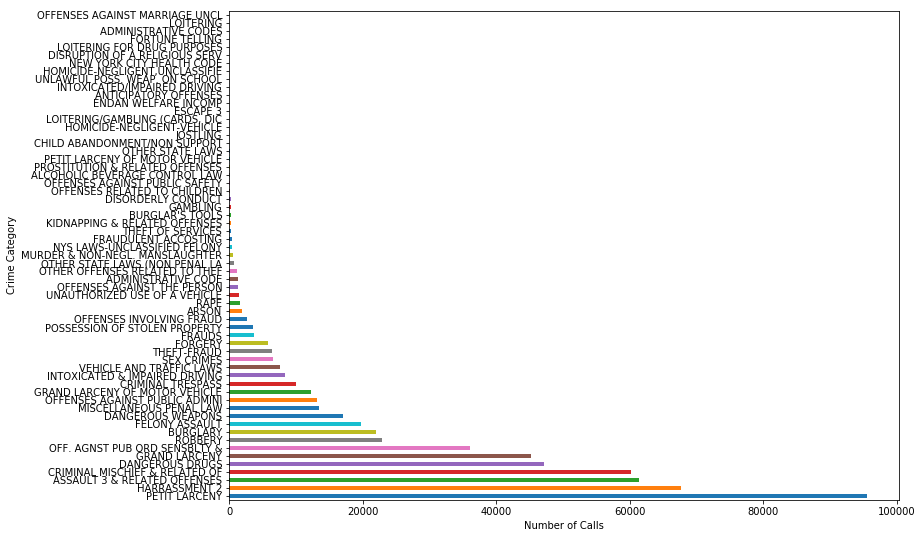

In [97]:
### BEGIN SOLUTION
crimes = calls['OFNS_DESC'].value_counts()
plt.xlabel('Number of Calls')
plt.ylabel('Crime Category')
crimes.plot(kind='barh')
### END SOLUTION

### 3.2 Getting a Better Plot
The plot above can be messy as it plots all offenses. Plot only the offenses that has more than 10000 calls

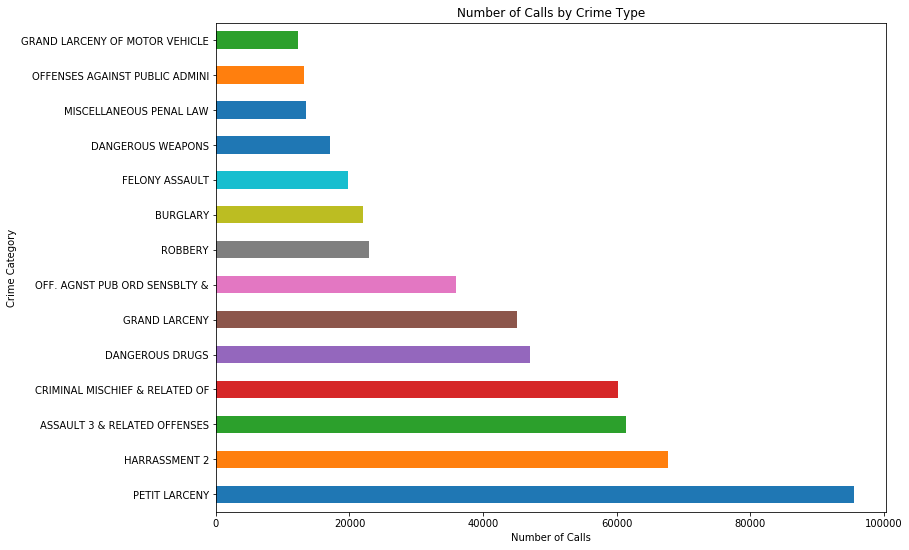

In [98]:
### BEGIN SOLUTION
topcrimes = calls['OFNS_DESC'].value_counts().head(14)
plt.xlabel('Number of Calls')
plt.ylabel('Crime Category')
topcrimes.plot(kind ='barh', title ='Number of Calls by Crime Type')


#a = (calls['OFNS_DESC'].value_counts() > 10000)
### END SOLUTION

By contrast, the Seaborn library provides a specific function `countplot` built for plotting counts. It operates directly on the DataFrame itself i.e. there's no need to call `value_counts()` at all. This higher level approach makes it easier to work with. Use the y-label ("Crime Category"), x-label("Number of Calls") and title_of_plot("Number of Calls By Crime Type"

[Text(0, 0.5, 'Crime Category'),
 Text(0.5, 0, 'Number of Calls'),
 Text(0.5, 1.0, 'Number of Calls by Crime type')]

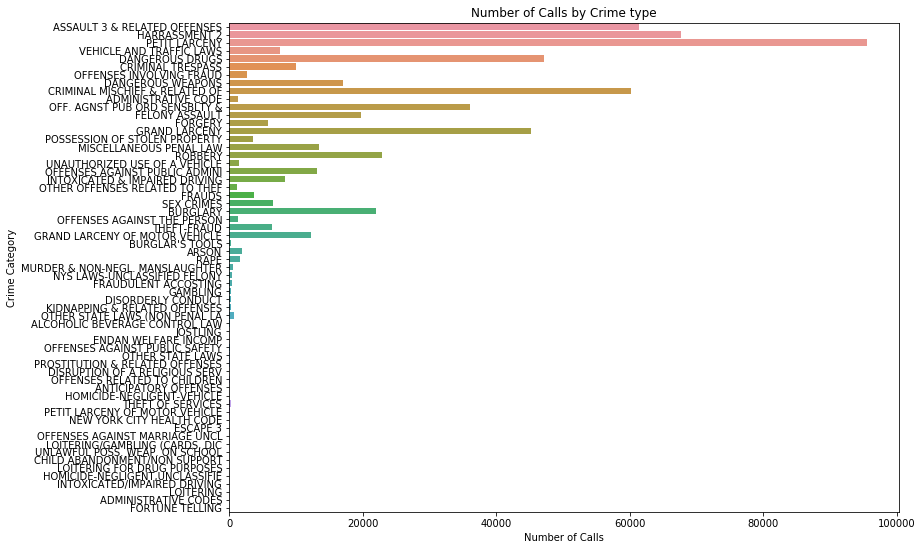

In [99]:
### BEGIN SOLUTION

ax = sns.countplot(y='OFNS_DESC', data = calls)
ax.set(xlabel="Number of Calls",ylabel="Crime Category", title="Number of Calls by Crime type")
### END SOLUTION

You may note that the ordering might be different for the seaborn plot (as compared to pandas plot). If we want the same ordering that we had in the pandas plot, we can use the order parameter of the `countplot` method. It takes a list of strings corresponding to the axis to be ordered. By passing the index of the `value_counts`, you can get the order you want.

[Text(0, 0.5, 'Crime Category'),
 Text(0.5, 0, 'Number of Calls'),
 Text(0.5, 1.0, 'Number of Calls by Crime type')]

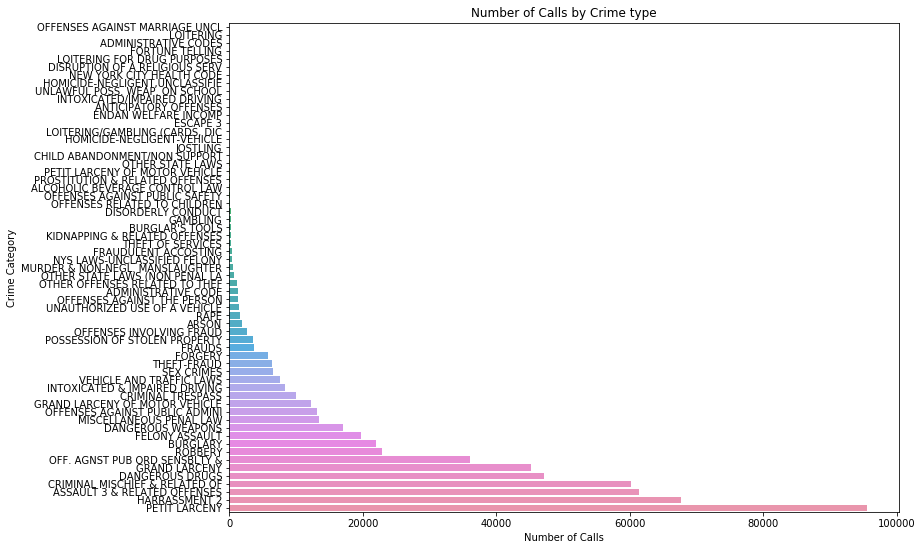

In [100]:
### BEGIN SOLUTION
ax = sns.countplot(y='OFNS_DESC', data = calls, order = calls['OFNS_DESC'].value_counts(ascending = True).index )
ax.set(xlabel="Number of Calls",ylabel="Crime Category", title="Number of Calls by Crime type")

### END SOLUTION

Now we have a pretty bar plot with the bars ordered by size. Though `seaborn` appears to provide a superior plot from a aesthetic point of view, the `pandas` plotting library is also good to understand. You'll get practice using both libraries in the following questions.

## An Additional Note on Plotting in Jupyter Notebooks

You may have noticed that many of our code cells involving plotting end with a semicolon (;). This prevents any extra output from the last line of the cell that we may not want to see. Try adding this to your own code in the following questions!

### 3.3 making more plots

Now it is your turn to make some more plots using `pandas` and `seaborn`. Let's start by looking at the distribution of calls over days of the week.

The CMPLNT_FR_DT field contains the date of the event. We would like to add a new column to the DataFrame that includes Day of the week (DAY_OF_WEEK) that indicates the day of the week. This can help us analyze the crimes on a specific day of the week. For example, we can answer questions such as "what day of the week that a LARSON is likely to happen in NYC?"


Add a new column `DAY_OF_WEEK` into the `calls` dataframe that has the day string (eg. 'Sunday') for the corresponding value in CMPLNT_FR_DT. For example, if the first 3 values of `CMPLNT_FR_DT` are `['01/27/2006, '01/28/2006, '01/29/2006]`, then the first 3 values of the `DAY_OF_WEEK` column should be `["Friday", "Saturday", "Sunday"]`.

**Hint:** *Try using the [Series.map](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) function on `calls["OFNS_DESC"]`.  Can you assign this to the new column `calls["DAY_OF_WEEK"]`?*

In [101]:
days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
### BEGIN SOLUTION
calls['CMPLNT_FR_DT'] = pd.to_datetime(calls['CMPLNT_FR_DT'])                  
calls["DAY_OF_WEEK"] = calls['CMPLNT_FR_DT'].dt.weekday_name
calls

### END SOLUTION

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,DAY_OF_WEEK
0,536868213,2009-03-13,18:00:00,03/13/2009,18:30:00,40.0,03/13/2009,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,NaN,40.814945,-73.914955,"(40.814945086, -73.914955302)",PATROL BORO BRONX,NaN,18-24,BLACK HISPANIC,F,Friday
1,445909921,2009-03-13,18:00:00,NaN,NaN,49.0,03/13/2009,578,HARRASSMENT 2,637.0,...,NaN,40.844996,-73.851674,"(40.84499609, -73.851673568)",PATROL BORO BRONX,NaN,65+,WHITE,M,Friday
2,695416668,2009-03-13,18:00:00,03/13/2009,18:15:00,70.0,03/13/2009,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,NaN,40.652105,-73.964341,"(40.652105473, -73.964341211)",PATROL BORO BKLYN SOUTH,NaN,65+,ASIAN / PACIFIC ISLANDER,F,Friday
3,848852896,2009-03-13,18:00:00,NaN,NaN,108.0,03/13/2009,341,PETIT LARCENY,338.0,...,NaN,40.744790,-73.932609,"(40.744790306, -73.932609266)",PATROL BORO QUEENS NORTH,NaN,25-44,ASIAN / PACIFIC ISLANDER,M,Friday
4,825196673,2009-03-13,18:00:00,03/13/2009,18:15:00,120.0,03/13/2009,348,VEHICLE AND TRAFFIC LAWS,916.0,...,NaN,40.636963,-74.117551,"(40.636962828, -74.11755085)",PATROL BORO STATEN ISLAND,NaN,<18,UNKNOWN,M,Friday
5,945292780,2009-03-13,18:00:00,03/13/2009,18:15:00,24.0,03/13/2009,341,PETIT LARCENY,338.0,...,NaN,40.793666,-73.971517,"(40.793665625, -73.971517339)",PATROL BORO MAN NORTH,NaN,18-24,BLACK,F,Friday
6,250262365,2009-03-13,18:00:00,03/13/2009,18:26:00,14.0,03/13/2009,341,PETIT LARCENY,333.0,...,NaN,40.750431,-73.989282,"(40.750430768, -73.989282176)",PATROL BORO MAN SOUTH,NaN,NaN,UNKNOWN,D,Friday
7,209785238,2009-03-13,18:00:00,NaN,NaN,66.0,03/13/2009,341,PETIT LARCENY,339.0,...,NaN,40.620251,-73.981991,"(40.62025084, -73.981990721)",PATROL BORO BKLYN SOUTH,NaN,18-24,BLACK,M,Friday
8,325047763,2009-03-13,17:50:00,NaN,NaN,26.0,03/13/2009,235,DANGEROUS DRUGS,567.0,...,NaN,40.821271,-73.946081,"(40.821271209, -73.946080665)",PATROL BORO MAN NORTH,NaN,NaN,UNKNOWN,E,Friday
9,963530455,2009-03-13,17:50:00,NaN,NaN,60.0,03/13/2009,235,DANGEROUS DRUGS,511.0,...,NaN,40.580903,-74.003443,"(40.580902779, -74.00344306)",PATROL BORO BKLYN SOUTH,NaN,NaN,UNKNOWN,E,Friday


### 3.4 Seaborn plots

Create a `seaborn` plot that shows the number of calls for each day of the week. You may want to use of the `rotation` argument in `ax.set_xticklabels`, which rotates the labels by 90 degrees.

[Text(0, 0.5, 'Number of Calls'),
 Text(0.5, 0, 'DAY_OF_WEEK'),
 Text(0.5, 1.0, 'Number of Calls by Crime type')]

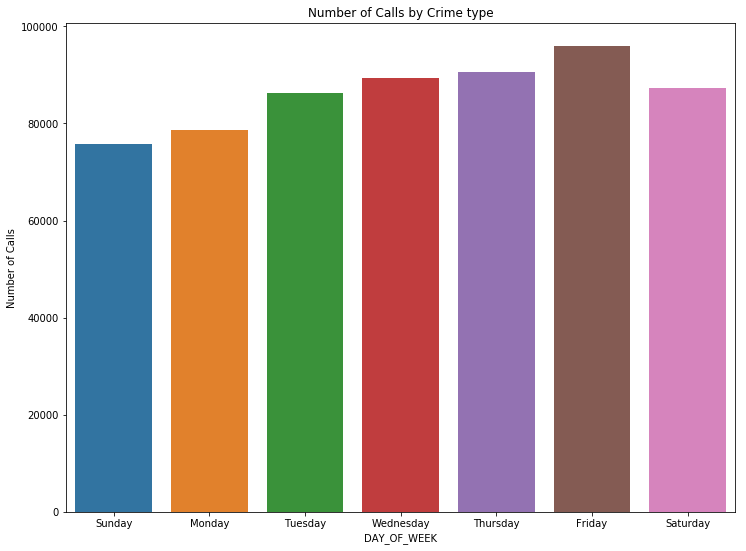

In [102]:
### BEGIN SOLUTION
ax = sns.countplot(x='DAY_OF_WEEK', data = calls, order = days)
ax.set(xlabel="DAY_OF_WEEK",ylabel="Number of Calls", title="Number of Calls by Crime type")

### END SOLUTION

Now, let's make the same plot using `pandas`. Construct a vertical bar plot with the count of the number of calls (entries in the table) for each day of the week **ordered by the day of the week** (eg. `Sunday`, `Monday`, ...). Do not use `sns` for this plot. Be sure that your axes are labeled and that your plot is titled.

**Hint:** *Given a series `s`, and an array `coolIndex` that has the same entries as in `s.index`, `s[coolIndex]` will return a copy of the series in the same order as `coolIndex`.*

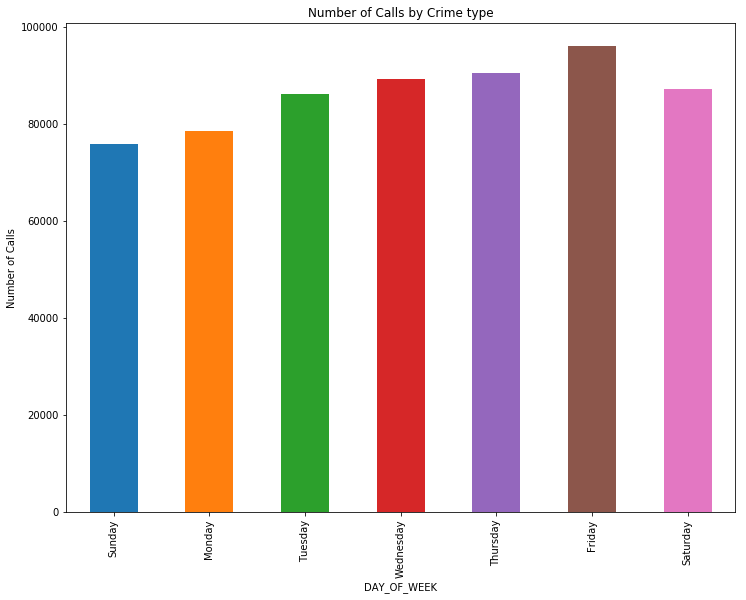

In [103]:
### BEGIN SOLUTION
ax = calls['DAY_OF_WEEK'].value_counts()[days]
plt.xlabel('DAY_OF_WEEK')
plt.ylabel('Number of Calls')
ax.plot(kind='bar', title ='Number of Calls by Crime type')
### END SOLUTION

## 3.5 What Day of the Week is more calls?

Is it true that weekdays generally have slightly more calls than Saturday or Sunday? What can you say about the difference?

##### BEGIN SOLUTION
Yes it is true that weekdays have slightly more calls than Saturday and Sunday. It seems that on Friday, the most calls are recieved. Wednesday and Thursday recieve more calls compared to the weekend and the number of calls recieved on Tuesday seems to be equal to number of calls recieved on Sunday.

##### END SOLUTION

We can break down into some particular types of events to see their distribution. For example, let's make a bar plot for the OFNS_DESC "HARRASSMENT 2". Which day is the peak for "HARRASSMENT 2"?

This time, use `seaborn` to create a vertical bar plot of the number of total noise violations reported on each day of the week, again ordered by the days of the week starting with Sunday. Do not use `pandas` to plot.

**Hint:** *If you're stuck, use the code for the seaborn plot in above question as a starting point.*

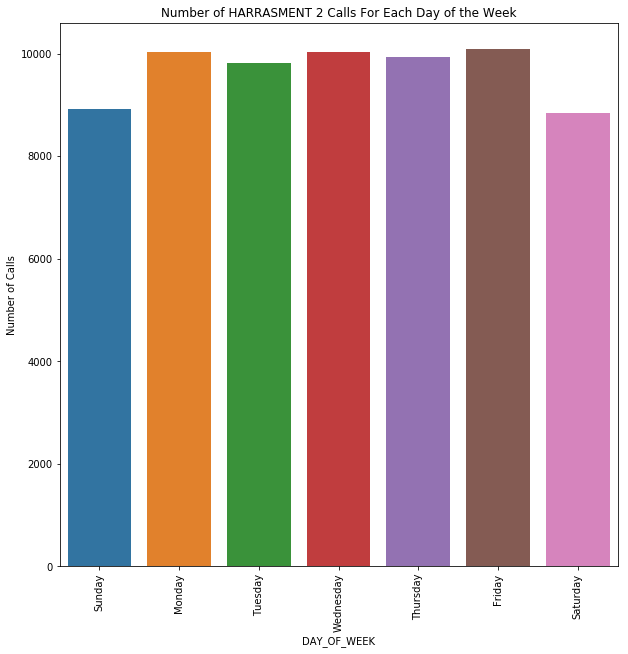

In [113]:
### BEGIN SOLUTION 
plt.figure(figsize=(10, 10))
plt.xticks(rotation=90)
filtered = calls[calls.OFNS_DESC == 'HARRASSMENT 2']
ax = sns.countplot(data=filtered, x='DAY_OF_WEEK', order=days)
ax.set(ylabel='Number of Calls')
ax.set_title('Number of HARRASMENT 2 Calls For Each Day of the Week')
ax
### END SOLUTION

### 3.6 

Do you see anything interesting about the distribution of HARRASSMENT 2 calls over a week? Type a short answer below.
##### BEGIN SOLUTION
There seems to be more calls regarding Harassment 2 during the weekdays as compared to the weekend. Compared to the graph above, they're similar in this case.
##### END SOLUTION

### 3.7 More Plots

Let's look at a similar distribution but for a crime we have much more calls data about. In the cell below, create the same plot as you did in previous questions, but now looking at instances of the OFNS_DESC "BURGLARY" (instead of "HARRASSMENT 2"). Use either `pandas` or `seaborn` plotting as you desire.

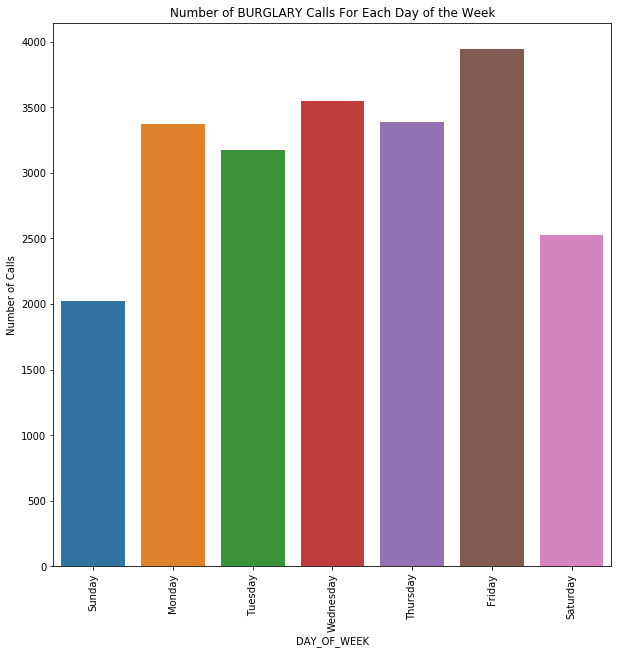

In [114]:
### BEGIN SOLUTION
plt.figure(figsize=(10, 10))
plt.xticks(rotation=90)
filtered = calls[calls.OFNS_DESC == 'BURGLARY']
ax = sns.countplot(data=filtered, x='DAY_OF_WEEK', order=days)
ax.set(ylabel='Number of Calls')
ax.set_title('Number of BURGLARY Calls For Each Day of the Week')
ax


### END SOLUTION



### 3.8 time of events

Now let's look at the CMPLNT_TO_TM column which indicates the time for events. Since it contains hour and minute information, let's extract the hour info and create a new column named `Hour` in the `calls` dataframe. You should save the hour as an `int`. Then plot the frequency of each hour in the table (i.e., `value_counts()`) sorted by the hour of the day (i.e., `sort_index()`).

You will want to look into how to use:

* [Series.str.slice](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.slice.html#pandas.Series.str.slice) to select the substring.
* [Series.astype](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.astype.html) to change the type.

**Hint:** *The `str` helper member of a series can be used to grab substrings.  For example, `calls["CMPLNT_TO_TM"].str.slice(3,5)` returns the minute of each hour of the `CMPLNT_TO_TM`.*

E:\anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


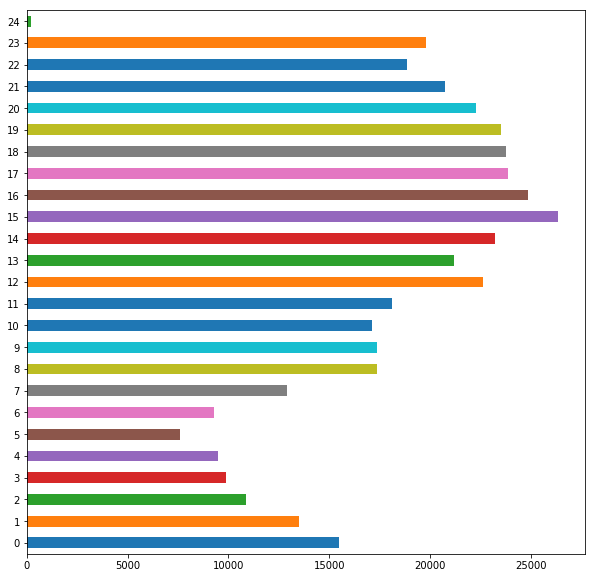

In [115]:
### BEGIN SOLUTION

calls = calls.dropna(subset=["CMPLNT_TO_TM"])
calls['Hour'] = calls["CMPLNT_TO_TM"].str.slice(0,2).astype('int')
ax = calls['Hour'].value_counts().sort_index().plot(kind='barh',figsize=(10,10))
ax

### END SOLUTION

Create a pandas bar plot showing the number of BURGLARY crimes committed at each hour of the day. Use the labels
* ax.set_xlabel("Hour of the Day")
* ax.set_ylabel("Number of Calls")
* ax.set_title("Number of Calls Reporting Fraud For Each Day of the Week");

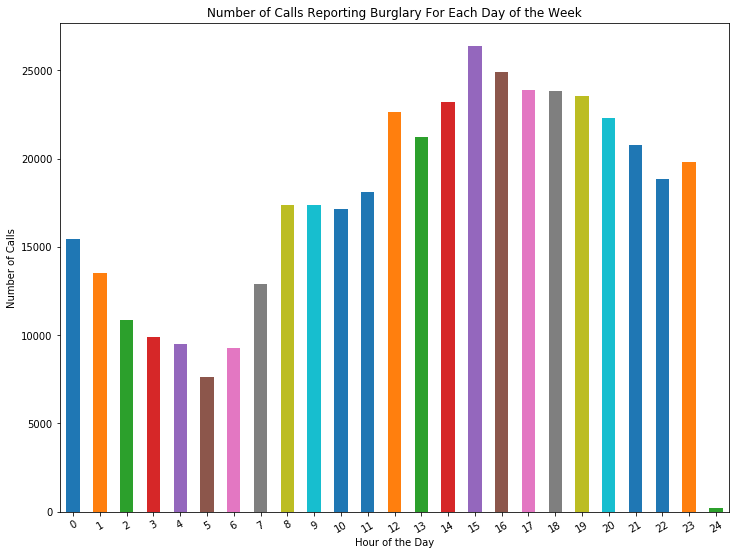

In [126]:
### BEGIN SOLUTION
filtered = calls[calls.OFNS_DESC == 'BURGLARY']
ax = calls['Hour'].value_counts(ascending=False).sort_index()
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Calls')
ax.plot(kind='bar', title ='Number of Calls Reporting Burglary For Each Day of the Week', rot=30)

### END SOLUTION

### 3.9 More plots

In the cell below, create a seaborn plot of the same data. Again, make sure you provide axes labels and a title for your plot.

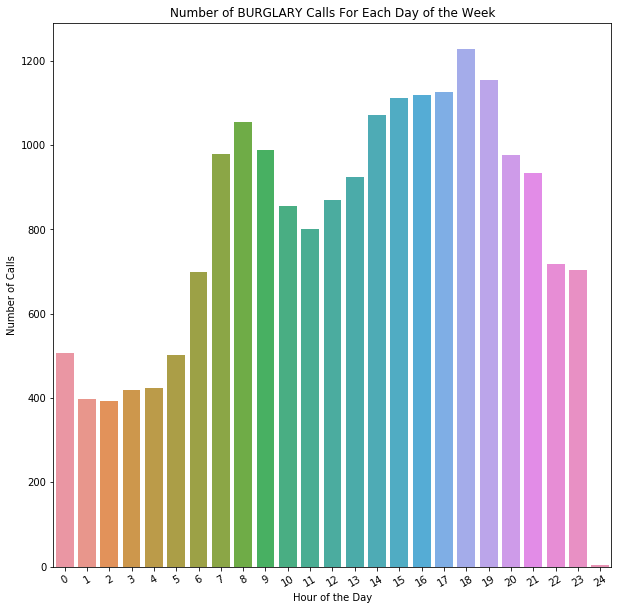

In [130]:
### BEGIN SOLUTION
plt.figure(figsize=(10, 10))
plt.xticks(rotation=30)
filtered = calls[calls.OFNS_DESC == 'BURGLARY']
ax = sns.countplot(data=filtered, x='Hour')
ax.set(ylabel='Number of Calls',xlabel='Hour of the Day')
ax.set_title('Number of BURGLARY Calls For Each Day of the Week')
ax
### END SOLUTION

### 3.8 Spike in burglary?

According to your plots, is there a spike in calls reporting BURGLARY at midnight? If so, Do you trust that this spike is legitimate, or could there be an issue with our data? Explain your reasoning in 1-2 sentences below.

#### BEGIN SOLUTION
Comparing to the rest of the hours of the day, there isn't much of a spike in Burglary at Midnight. However thought, the spike is questionable comsidering Hour 0 and Hour 24 is supposed to be the same and there could be an issue with the data as it might have issues with ambiguous dates.

#### END SOLUTION

In the cell below, we generate a boxplot which examines the hour of day of each crime broken down by the `OFNS_DESC` value.  To construct this plot we used the [DataFrame.boxplot](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.boxplot.html) documentation.

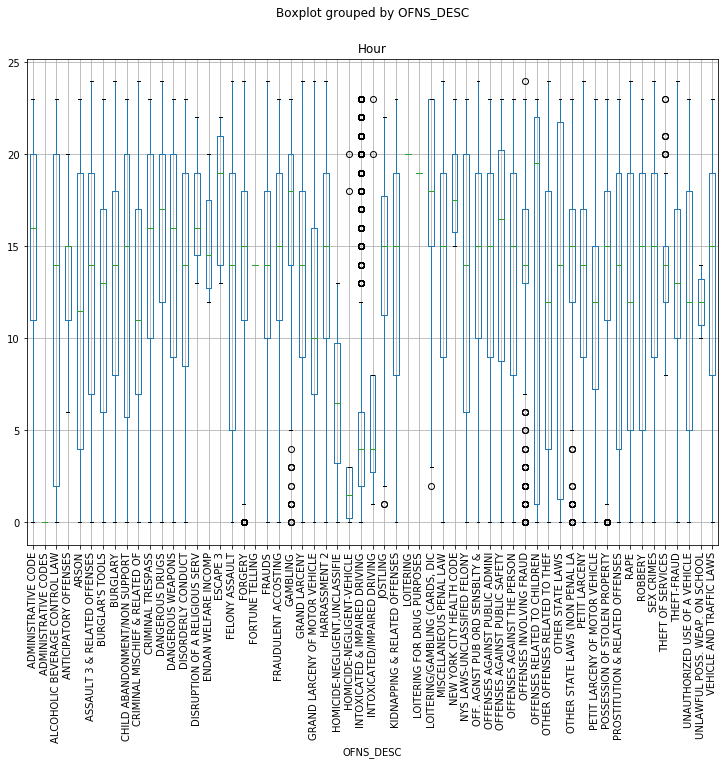

In [131]:
calls.boxplot(column="Hour", by='OFNS_DESC', rot=90);

While the pandas boxplot is informative, we can use seaborn to create a more visually-appealing plot. Using seaborn, regenerate a better box plot. See either the textbook (https://www.textbook.ds100.org/ch/06/viz_quantitative.html) or the [seaborn boxplot documentation](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

Looking at your plot, which crime type appears to have the largest interquartile range? Put your results into `answer` as a string.

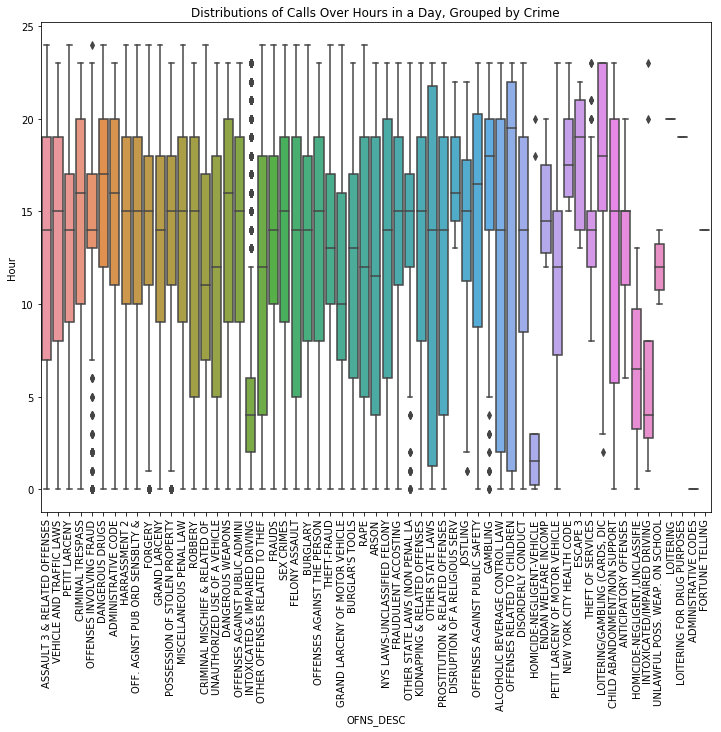

In [135]:
# Todo: Make a boxplot with seaborn
### BEGIN SOLUTION
ax = sns.boxplot(data=calls, x='OFNS_DESC', y = 'Hour' );
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title("Distributions of Calls Over Hours in a Day, Grouped by Crime");
answer = "OFFENSES RELATED TO CHILDREN"
### END SOLUTION

### 3.9 - Visualization of crimes on a Map of NYC
finally we attempt to visualize the crimes committed in NYC on a Map. First we need to installing some mapping software. run the cell below to install folium package for mapping software.

In [75]:
!pip install --upgrade folium

In [1]:
### Plot the maps for BURGLARY in NYC
### if it takes too much time or map does not show up, try plotting a subset of the data set of for a specific crime

### BEGIN SOLUTION
import folium
import folium.plugins as plugins
calls2 = calls[calls.OFNS_DESC == 'BURGLARY']
calls3 = calls2[calls2.PD_DESC == 'BURGLARY,TRUCK NIGHT']
#calls2["PD_DESC"].value_counts()
map = folium.Map(location=[40.624149976, -73.977430585])

for index, row in calls3[0:100].iterrows():
    folium.Marker([row['Latitude'], row['Longitude']])
#location = calls3[['Latitude', 'Longitude']].as_matrix()
map
### END SOLUTION

ModuleNotFoundError: No module named 'folium'

Credits: Josh Hug, and Berkeley Data Science Group for their contributions to the original version.